# ◆Kickstarter Projects
### 目的：クラウドファンディングが成功するかを事前に予測する
### 目的変数をstate（成功 or 失敗）とする二値分類の予測モデルを構築する
- kaggle URL:https://www.kaggle.com/kemical/kickstarter-projects
- Create Date：2020/01/15　Author：M.Hasegawa
### ────────────────────────────────────────────────────────────────

### 【手順】

### 0.Notebook内で利用する関数の定義

### 1.データ読込
- 欠損項目を確認する

### 2.データ前処理
- 予測時に利用できない項目は、除外する。
- 目的変数を説明するのに有効そうな説明変数を見つけグラフを作成する。
- 無相関化を実施する。
- ホールドアウト法でデータ分割する。
- カテゴリ変換する。
- 標準化（白色化）を実施する。

### 3.モデル構築
- 各アルゴリズムのハイパーパラメータ探索を行う。（ロジスティック回帰とSVMを利用）

### 4.モデル評価
- 最良のモデルで汎化性能を算出する。
- 混同行列を作成し、Accuracy、Recall、Precisionを求める

### ※データセット
- 「ks-projects-201801.csv」（データ数：378,661行15列）

| 列 | 項目 | 項目名 | 欠損有無 | 利用概要 |
|:---:|:---:|:---:|:---:|:---:|
|  1 | ID| 識別ID | - | 不要と思われる為除外 |
|  2 | name |名称 | 欠損あり | ○※文字数を算出して利用 |
|  3 | category |カテゴリ | - | ○ |
|  4 | main_category |主なカテゴリ | - | ○ |
|  5 | currency |使用通貨 | - | ○ |
|  6 | deadline |締切日 | - | ○※期間算出 |
|  7 | goal |目標調達資金額 | - | ×※usd_goal_realを使うため除外 |
|  8 | launched |開始日時 | - | ○※期間算出,月,日,時間を抽出 |
|  9 | pledged |集まった資金 | - | 予測できないため除外 |
| 10 | state |プロジェクトの状態 | - | ◎※目的変数で利用（成功と失敗のみ抽出） |
| 11 | backers |支援者数 | - | 予測できないため除外 |
| 12 | country|国 | - | ○ |
| 13 | usd_pledged |集まった資金（米ドル） | 欠損あり | 予測できないため除外 |
| 14 | usd_pledged_real |集まった資金（米ドル） | - | 予測できないため除外 |
| 15 | usd_goal_real |目標金額（米ドル） | - | ○ |

## 0.Notebook内で利用する関数の定義

In [1]:
%matplotlib inline
import datetime
import pandas  as pd
import numpy   as np
import seaborn as sns
import category_encoders as ce
import matplotlib.pyplot as plt
from time                    import time
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve
from sklearn.linear_model    import SGDClassifier
from sklearn.svm             import SVC
from sklearn.metrics         import log_loss, accuracy_score, confusion_matrix,precision_recall_fscore_support
from sklearn.model_selection import train_test_split
from sklearn.preprocessing   import StandardScaler
from IPython.display         import Markdown, display
import warnings
warnings.filterwarnings('ignore')

start_notebook = time()

# ****************************************************************************
# 設定値
# ****************************************************************************

# ▼件数絞込用（時間がかかりすぎるため）
squeeze_num = 11000 # ※1以上の場合有効

decorr_flg = True # 無相関化するか

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 30)

# ============================================================================
# 結果をテキストファイルへ出力
# ============================================================================
def f_write(string):
    f = open('./result.txt', 'a') #追記
    dt_now = datetime.datetime.now()
    f.write('\n'+ dt_now.strftime('%Y/%m/%d %H:%M:%S') + '： ' + string) 
    f.close()
    
# ============================================================================
# MarkDown記法
# ============================================================================
def printmd(string):
    display(Markdown('\n\n**' + string + '**'))
    
# ============================================================================
# 関数：成功と失敗別のヒストグラムと歪度
# 引数：データ名,グラフの横幅、縦幅、刻み数（棒の数）
# ============================================================================
def show_histogram(col_name,w,h,bins_val):
    printmd('▼ ' + str(col_name) + 'の分布 ※歪度：' + str(df[col_name].skew()))
    plt.figure(figsize=(w,h))
    sns.distplot(df[df['state']==0][col_name],kde=False,rug=False,bins=bins_val,label='failed')
    sns.distplot(df[df['state']==1][col_name],kde=False,rug=False,bins=bins_val,label='successful')
    plt.title('Histogram of ' + str(col_name) + ' (bins = ' + str(bins_val) + ')')
    plt.grid(which='major',color='gray',linestyle=':')
    plt.grid(which='minor',color='gray',linestyle=':')
    plt.legend()
    plt.show()

# ============================================================================
# 関数：対数変換した成功と失敗別のヒストグラム
# 引数：データ名,グラフの横幅、縦幅、刻み数（棒の数）
# ============================================================================
def show_histogram_log1p(col_name,w,h,bins_val):
    printmd('▼ 対数変換した' + str(col_name) + 'の分布')
    plt.figure(figsize=(w,h))
    sns.distplot(np.log1p(df[df['state']==0][col_name]),kde=False,rug=False,bins=bins_val,label='failed')
    sns.distplot(np.log1p(df[df['state']==1][col_name]),kde=False,rug=False,bins=bins_val,label='successful')
    plt.title('Histogram of ' + str(col_name) + ' (bins = ' + str(bins_val) + ')')
    plt.grid(which='major',color='gray',linestyle=':')
    plt.grid(which='minor',color='gray',linestyle=':')
    plt.xlabel(col_name)
    plt.legend()
    plt.show()
    
# ============================================================================
# 関数：成功と失敗別に散布図を表示するグラフ
# 引数：データ名,グラフの横幅、縦幅
# ============================================================================
def show_scatter_plot(col_name, w, h):
    printmd('▼ ' + str(col_name) + 'の散布図')
    plt.figure(figsize=(w,h))
    data1 = df.query('state == 1') # 成功
    data2 = df.query('state == 0') # 失敗
    plt.grid(which='major',color='black',linestyle=':')
    plt.grid(which='minor',color='black',linestyle=':')
    plt.plot(data1.index, data1[col_name], 'o', color='C1', label='successful')
    plt.plot(data2.index, data2[col_name], 'x', color='C0', label='failed')
    plt.legend(loc='best')
    plt.title('Scatter plot of ' + str(col_name))
    plt.grid(which='major',color='gray',linestyle=':')
    plt.grid(which='minor',color='gray',linestyle=':')
    plt.ylabel(col_name)
    plt.xlabel('row_index')
    plt.show()
    
# ============================================================================
# 関数：2項目の相関関係と成功失敗を色分けして散布図を表示するグラフ
# 引数：データ名,グラフの横幅、縦幅
# ============================================================================
def show_corr_scatter_plot(col_name1, col_name2, w, h):
    printmd('▼ ' + str(col_name1) + ' と ' + str(col_name2) + ' の相関 ※相関係数: {:.3f}'.format(
    np.corrcoef(df[col_name1].values,df[col_name2].values)[0,1]))
    plt.figure(figsize=(w,h))
    data1 = df.query('state == 1') # 成功
    data2 = df.query('state == 0') # 失敗
    plt.grid(which='major',color='black',linestyle=':')
    plt.grid(which='minor',color='black',linestyle=':')
    plt.plot(data1[col_name1], data1[col_name2], 'o', color='C1', label='successful')
    plt.plot(data2[col_name1], data2[col_name2], 'x', color='C0', label='failed')
    plt.legend(loc='best')
    plt.title('Scatter plot of ' + str(col_name1) + ' and ' + str(col_name1))
    plt.grid(which='major',color='gray',linestyle=':')
    plt.grid(which='minor',color='gray',linestyle=':')
    plt.xlabel(col_name1)
    plt.ylabel(col_name2)
    plt.show()

# ============================================================================
# 関数：成功数と失敗数別にカウント表示するグラフ
# 引数：データ名,グラフの横幅、縦幅、降順ソート有無、xラベルの回転
# ============================================================================
def show_state_count_plot(col_name, w, h, sort_flg=False, x_rot = 0):
    plt.figure(figsize=(w,h))
    if(sort_flg):
        printmd('▼ ' + str(col_name) + '別の成功数と失敗数（降順）')
        ax = sns.countplot(df[col_name],hue=df['state'],order = df[col_name].value_counts().index)
    else:
        printmd('▼ ' + str(col_name) + '別の成功数と失敗数')
        ax = sns.countplot(df[col_name],hue=df['state'])
        
    ax.set_title('Count by ' + str(col_name))
    plt.grid(which='major',color='lightgray',linestyle=':')
    plt.grid(which='minor',color='lightgray',linestyle=':')
    ax.set_xlabel(col_name)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=x_rot, ha="right") # ラベルの回転
    ax.set_ylabel('Count')
    plt.legend()
    plt.show()

# ============================================================================
# 関数：成功率を棒グラフで比較するグラフ
# 引数：データ名,グラフの横幅、縦幅、平均値、降順ソート有無、xラベルの回転
# ============================================================================
def show_successrate_barplot(col_name, w, h, baseline, sort_flg=False, x_rot = 0):
    # stateの平均値が成功率になる（成功率＝成功の件数/全体の件数）
    successrate = pd.DataFrame(df['state'].groupby(df[col_name]).mean())
    successrate.reset_index(inplace = True) # index振り直し
    if(sort_flg):
        successrate = successrate.sort_values('state', ascending=False) # 成功率の降順
        printmd('▼ ' + str(col_name) + '別の成功率（降順）※赤線：学習データの平均成功率')
    else:
        printmd('▼ ' + str(col_name) + '別の成功率 ※赤線：学習データの平均成功率')
    plt.figure(figsize=(w,h))
    ax = sns.barplot(x=col_name, y="state", data=successrate)
    ax.axhline(baseline, alpha=0.5, color='red') # 平均値
    ax.set_title('Success rate by ' + str(col_name))
    plt.grid(which='major',color='lightgray',linestyle=':')
    plt.grid(which='minor',color='lightgray',linestyle=':')
    ax.set_xlabel(col_name)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=x_rot, ha="right") # ラベルの回転
    ax.set_ylabel('Ratio')
    plt.show()

# ============================================================================
# 学習曲線を作成
# モデル、タイトル、X,y
# ============================================================================
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,n_jobs=-1,train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure(figsize=(6,4))
    plt.title(title)
    plt.xlabel("Training examples")
    plt.ylabel("Accuracy Score")
    
    # 学習曲線
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, 
                                                            train_sizes=train_sizes,
                                                           random_state=1234)
    train_scores_mean = np.mean(train_scores, axis=1) # 分割数分のスコアの平均
    train_scores_std  = np.std(train_scores, axis=1) # 分割数分のスコアの標準偏差
    test_scores_mean  = np.mean(test_scores, axis=1) # 分割数分のスコアの平均
    test_scores_std   = np.std(test_scores, axis=1) # 分割数分のスコアの標準偏差
    
    #print('\ntrain_sizes=\n',train_sizes)
    #print('\ntrain_scores_mean=\n',train_scores_mean)
    #print('\ntrain_scores_std=\n',train_scores_std)
    #print('\ntest_scores_mean=\n',test_scores_mean)
    #print('\ntest_scores_std=\n',test_scores_std)
    
    plt.grid()
    # 標準偏差の範囲を色付け（学習データ）
    plt.fill_between(train_sizes, 
                     train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, 
                     alpha=0.1,
                     color="r")
    # 標準偏差の範囲を色付け（交差検証法）
    plt.fill_between(train_sizes, 
                     test_scores_mean - test_scores_std, 
                     test_scores_mean + test_scores_std, 
                     alpha=0.1, color="g")
    # 学習データのスコアをプロット
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    # 交差検証法スコアをプロット
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    plt.legend(loc="best")
    plt.show()


# 1.データ読込

In [2]:
f_write('\n-------------------------------------------------------------------')
f_write('▼処理開始')

df= pd.read_csv('./ks-projects-201801.csv',parse_dates=['deadline', 'launched'])

printmd('▼ 先頭3行表示')
display(df.head(3))

printmd('▼ 基本統計量')
display(df.describe())

printmd('▼ 欠損データ確認')
display(pd.DataFrame(df.isnull().sum()[df.isnull().sum()>0],columns=['Missing num']))



**▼ 先頭3行表示**

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0,220.0,45000.00




**▼ 基本統計量**

,ID,goal,pledged,backers,usd pledged,usd_pledged_real,usd_goal_real
count,3.786610e+05,3.786610e+05,3.786610e+05,378661.000000,3.748640e+05,3.786610e+05,3.786610e+05
mean,1.074731e+09,4.908079e+04,9.682979e+03,105.617476,7.036729e+03,9.058924e+03,4.545440e+04
std,6.190862e+08,1.183391e+06,9.563601e+04,907.185035,7.863975e+04,9.097334e+04,1.152950e+06
min,5.971000e+03,1.000000e-02,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,1.000000e-02
25%,5.382635e+08,2.000000e+03,3.000000e+01,2.000000,1.698000e+01,3.100000e+01,2.000000e+03
50%,1.075276e+09,5.200000e+03,6.200000e+02,12.000000,3.947200e+02,6.243300e+02,5.500000e+03
75%,1.610149e+09,1.600000e+04,4.076000e+03,56.000000,3.034090e+03,4.050000e+03,1.550000e+04
max,2.147476e+09,1.000000e+08,2.033899e+07,219382.000000,2.033899e+07,2.033899e+07,1.663614e+08




**▼ 欠損データ確認**

,Missing num
name,4
usd pledged,3797


# 2.データ前処理
## 2-1.説明変数の選定



**▼ 先頭3行表示**

,ID,name,category,main_category,currency,deadline,goal,launched,state,country,usd_goal_real,name_char_length,name_word_num,name_end_char,period,launched_month,launched_day,launched_hour,deadline_month,deadline_day
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,failed,GB,1533.95,26,6,h,58,8,11,12,10,9
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,failed,US,30000.00,38,8,T,59,9,2,4,11,1
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,failed,US,45000.00,12,3,?,44,1,12,0,2,26




**▼ 説明変数（数値項目）同士の相関係数をヒートマップにして可視化**

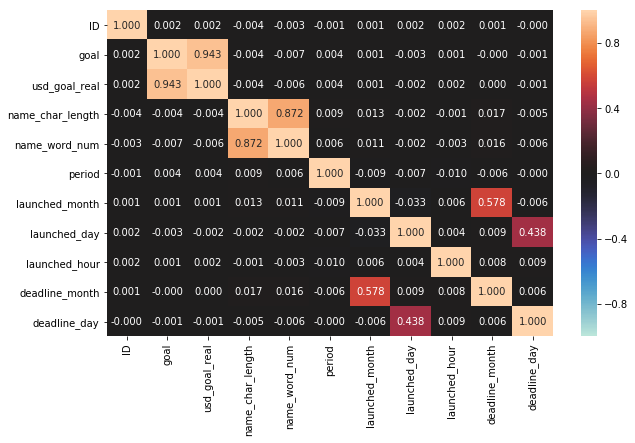

→goalとusd_goal_realは、ほぼ同じなので、goalを除外して、usd_goal_realを利用する。
→name_word_numとname_char_lengthは、正の相関があるので無相関化を検討する。


In [3]:
# 予測時に利用できない項目を削除
df = df.drop(['backers'], axis=1)          # 集客数は予測時に利用できない為、除外
df = df.drop(['pledged'], axis=1)          # 集まった資金は予測時に利用できない為、除外
df = df.drop(['usd pledged'], axis=1)      # 欠損があり、集まった資金は予測時に利用できない為、除外
df = df.drop(['usd_pledged_real'], axis=1) # 集まった資金は予測時に利用できない為、除外

# 説明変数になりそうな項目を追加
df['name_char_length'] = df['name'].apply(lambda x: len(str(x).replace(' ', ''))) # nameの文字数
df['name_word_num'] = df['name'].apply(lambda x: len(str(x).split(' ')))          # nameの単語数   ・・・追加
df['name_end_char'] = df['name'].apply(lambda x: str(x).replace(' ', '')[-1])     # nameの最終文字 ・・・追加
df['period'] = (df['deadline'] - df['launched']).dt.days  # 開始日時と終了日から期間を算出
df['launched_month'] = df['launched'].dt.month            # 開始時期の月に着目
df['launched_day'] = df['launched'].dt.day                # 開始時期の日に着目
df['launched_hour'] = df['launched'].dt.hour              # 開始時期の時間に着目
df['deadline_month'] = df['deadline'].dt.month            # 終了時期の月に着目・・・追加
df['deadline_day'] = df['deadline'].dt.day                # 終了時期の日に着目・・・追加

printmd('▼ 先頭3行表示')
display(df.head(3))

# ヒートマップ
printmd('▼ 説明変数（数値項目）同士の相関係数をヒートマップにして可視化')
plt.figure(figsize=(10,6))
sns.heatmap(df.corr(), annot=True, fmt='1.3f', vmax=1, vmin=-1, center=0)
plt.show()
print('→goalとusd_goal_realは、ほぼ同じなので、goalを除外して、usd_goal_realを利用する。')
print('→name_word_numとname_char_lengthは、正の相関があるので無相関化を検討する。')

# 説明変数にはならなそうな項目を除外
df = df.drop(['ID'], axis=1)               # 不要と考え除外
df = df.drop(['name'], axis=1)             # 欠損があり、説明変数にするには難しいと思われるので除外
df = df.drop(['goal'], axis=1)             # usd_goal_realとほぼ等しい為、除外

# 抽出元の不要な項目を削除
df = df.drop(['launched'], axis=1)
df = df.drop(['deadline'], axis=1)

## 2-2.目的変数の前処理



**▼ 目的変数 stateの種類（%）**

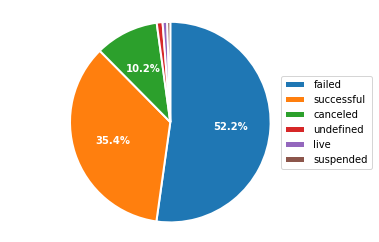

→成功と失敗以外のデータが1割程度あり、これらは不要と考えて除外する。




**▼ stateが成功または失敗のデータを抽出**

,state
failed,197719
successful,133956




**▼ 成功率の平均値**

baseline= 0.4038772895153388


In [4]:
printmd('▼ 目的変数 stateの種類（%）')
per_state = round(df['state'].value_counts() / len(df['state']) * 100,2)
values = list(per_state.values)

# 円グラフ
plt.figure(figsize=(4,4))
plt.pie(values, labels=list(per_state.index),
        wedgeprops={'linewidth': 2,'edgecolor':'white'},
        textprops={'color': 'white', 'weight': 'bold'},
        counterclock=False,startangle=90,
        autopct=lambda p: '{:.1f}%'.format(p) if p >= 2.5 else '')
lgnd=plt.legend(bbox_to_anchor=(1.0, 0.25, 1.55, 0.5), loc="center left", borderaxespad=0.)
plt.axis('equal')
plt.show()
print('→成功と失敗以外のデータが1割程度あり、これらは不要と考えて除外する。')

# stateが成功または失敗のデータを抽出
df = df.query('state in ["successful", "failed"]')

printmd('▼ stateが成功または失敗のデータを抽出')
display(pd.DataFrame(df['state'].value_counts(),columns=['state']))

# 変換（成功=1，失敗=0）
df['state'] = df['state'].map({'failed': 0,'successful': 1})

# 成功率の平均
printmd('▼ 成功率の平均値')
baseline = df['state'].mean()
print('baseline=',baseline)


## 2-3.各説明変数と目的変数の関係を確認
### 2-3-1.期間（period）



**▼ periodの分布 ※歪度：1.2535940368557628**

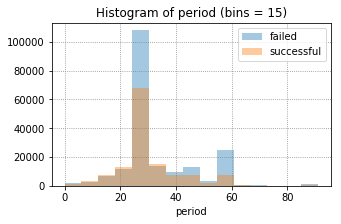

→失敗よりも成功が多い期間がある。




**▼ period別の成功数と失敗数**

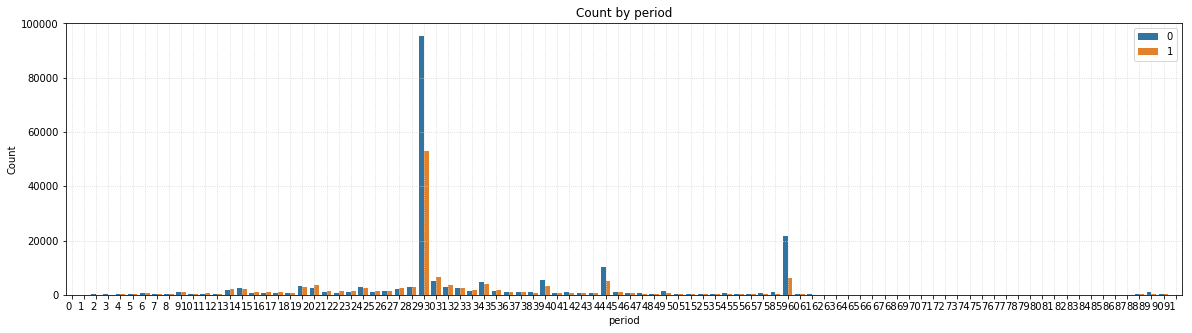

→連続している期間(日数)でも、結構凸凹しているので、ダミー変換することを考える。




**▼ period別の成功率 ※赤線：学習データの平均成功率**

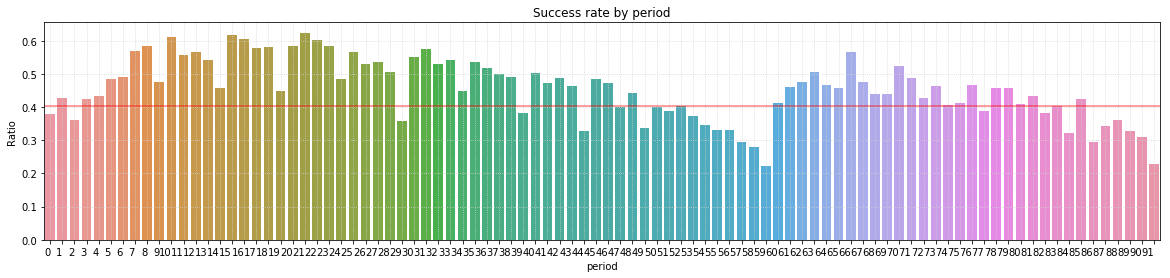

→成功率の平均値（赤線）に対して大きく差がでている為、期間(日数)が説明変数に何らかの影響を与えていると考えられる。


In [5]:
show_histogram('period',5,3,15)
print('→失敗よりも成功が多い期間がある。')

# 期間(日数)の分布を確認
show_state_count_plot('period',20,5)
print('→連続している期間(日数)でも、結構凸凹しているので、ダミー変換することを考える。')

# 期間(日数)別の成功率を確認
show_successrate_barplot("period",20,4,baseline,False)
print('→成功率の平均値（赤線）に対して大きく差がでている為、期間(日数)が説明変数に何らかの影響を与えていると考えられる。')

### 2-3-2. 目標金額（usd_goal_real）



**▼ usd_goal_realの散布図**

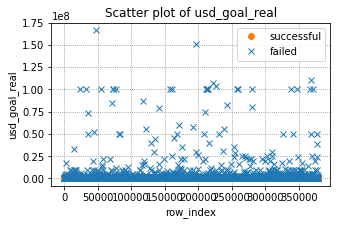

→目標金額が高すぎるものは、失敗している。




**▼ usd_goal_realの分布 ※歪度：83.10938853908664**

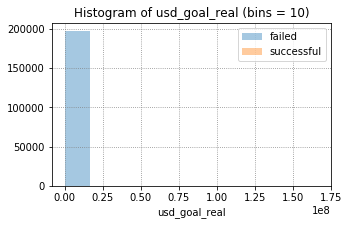

→左に偏っており、目標金額の歪度が大きい為、対数変換して分布を修正する




**▼ 対数変換したusd_goal_realの分布**

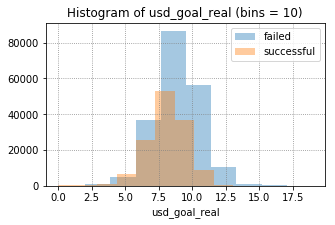

→全体的に目標金額が高くなると失敗しやすくなりそう。


In [6]:
# 外れ値がないか散布図で確認
show_scatter_plot('usd_goal_real',5,3)
print('→目標金額が高すぎるものは、失敗している。')
# 目標金額の分布
show_histogram('usd_goal_real',5,3,10)
print('→左に偏っており、目標金額の歪度が大きい為、対数変換して分布を修正する')
show_histogram_log1p('usd_goal_real',5,3,10)
print('→全体的に目標金額が高くなると失敗しやすくなりそう。')

### 2-3-3. 開始時期（launched_month、launched_day、launched_hour）



**▼ launched_month別の成功数と失敗数**

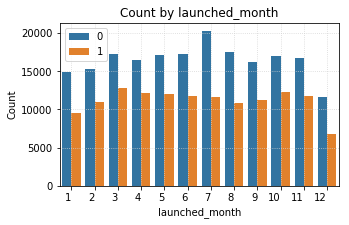



**▼ launched_month別の成功率 ※赤線：学習データの平均成功率**

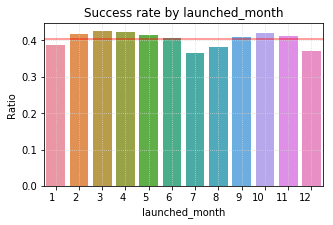

→春と秋あたりに開始すると成功率が若干高まる。




**▼ launched_day別の成功数と失敗数**

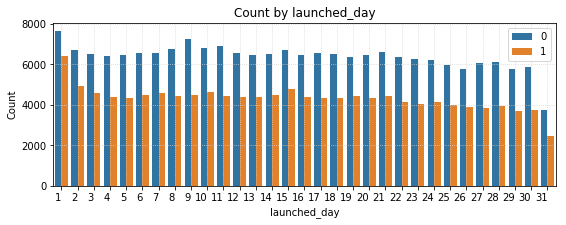



**▼ launched_day別の成功率 ※赤線：学習データの平均成功率**

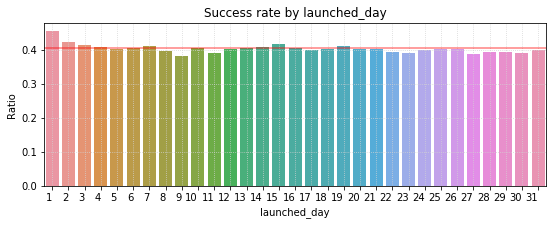

→月の上旬（特に1日開始）の成功率が若干高い。




**▼ launched_hour別の成功数と失敗数**

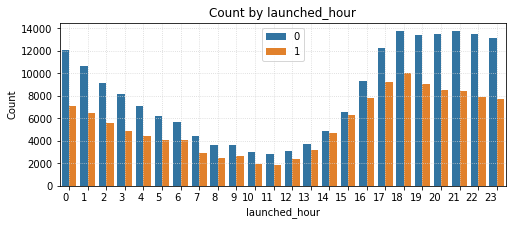



**▼ launched_hour別の成功率 ※赤線：学習データの平均成功率**

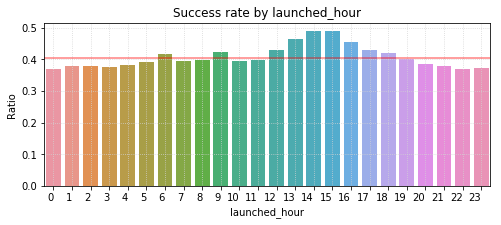

→午後2,3時あたりに開始すると成功率が高まるようだ。


In [7]:
show_state_count_plot('launched_month',5,3)
show_successrate_barplot('launched_month',5,3,baseline)
print('→春と秋あたりに開始すると成功率が若干高まる。')

show_state_count_plot('launched_day',9,3)
show_successrate_barplot("launched_day",9,3,baseline)
print('→月の上旬（特に1日開始）の成功率が若干高い。')

show_state_count_plot('launched_hour',8,3)
show_successrate_barplot("launched_hour",8,3,baseline)
print('→午後2,3時あたりに開始すると成功率が高まるようだ。')

### 2-3-4. 終了時期（deadline_month、deadline_day）



**▼ deadline_month別の成功数と失敗数**

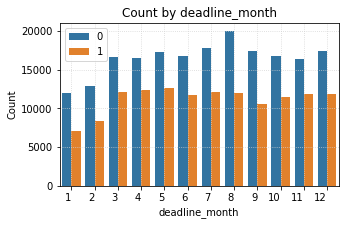



**▼ deadline_month別の成功率 ※赤線：学習データの平均成功率**

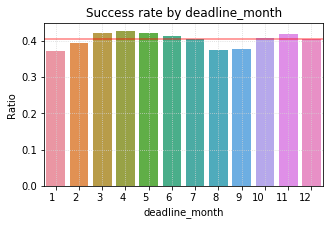



**▼ deadline_day別の成功数と失敗数**

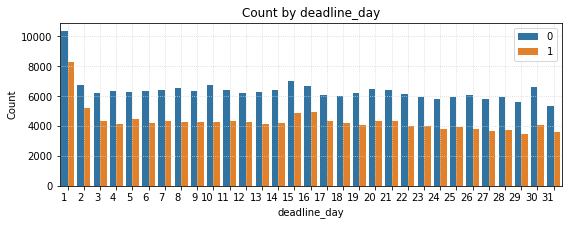



**▼ deadline_day別の成功率 ※赤線：学習データの平均成功率**

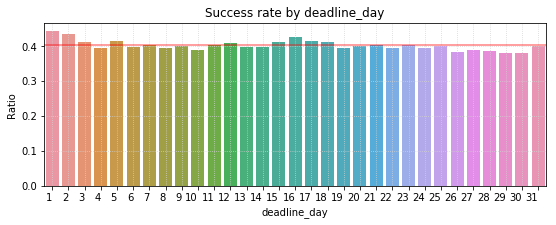

In [8]:
show_state_count_plot('deadline_month',5,3)
show_successrate_barplot('deadline_month',5,3,baseline)

show_state_count_plot('deadline_day',9,3)
show_successrate_barplot("deadline_day",9,3,baseline)

### 2-3-5. 主なカテゴリとカテゴリ（main_category、category）



**▼ main_categoryとcategory別のカウントと成功率**

state          
                                count      mean
main_category category                         
Art           Art                7486  0.452177
              Ceramics            275  0.480000
              Conceptual Art      930  0.393548
              Digital Art        1171  0.316823
              Illustration       2890  0.562630
              Installations       436  0.534404
              Mixed Media        2513  0.376045
              Painting           3035  0.378583
              Performance Art    1974  0.473151
              Public Art         2850  0.541404
              Sculpture          1657  0.421243
              Textiles            250  0.308000
              Video Art           174  0.293103
Comics        Anthologies         386  0.784974
              Comic Books        2493  0.647413
...                               ...       ...
Technology    Robots              496  0.455645
              Software           2573  0.144190
              Sound               551  0.497278
              Space Exploration   283  0.424028
              Technology         5726  0.230003
              Wearables           967  0.401241
              Web                3237  0.079703
Theater       Comedy               92  0.663043
              Experimental        342  0.616959
              Festivals           512  0.630859
              Immersive           297  0.569024
              Musical             830  0.556627
              Plays              1291  0.622773
              Spaces              194  0.510309
              Theater            6684  0.659037

[170 rows x 2 columns]

→main_categoryとcategoryは別々で考慮したほうが良さそう。




**▼ main_category別の成功数と失敗数（降順）**

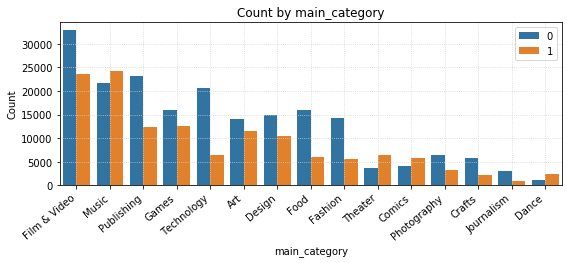



**▼ main_category別の成功率（降順）※赤線：学習データの平均成功率**

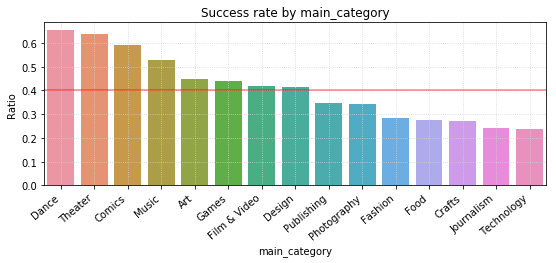

→成功しやすいmain_categoryと失敗しやすいmain_categoryがありそう。




**▼ category別の成功数と失敗数（降順）**

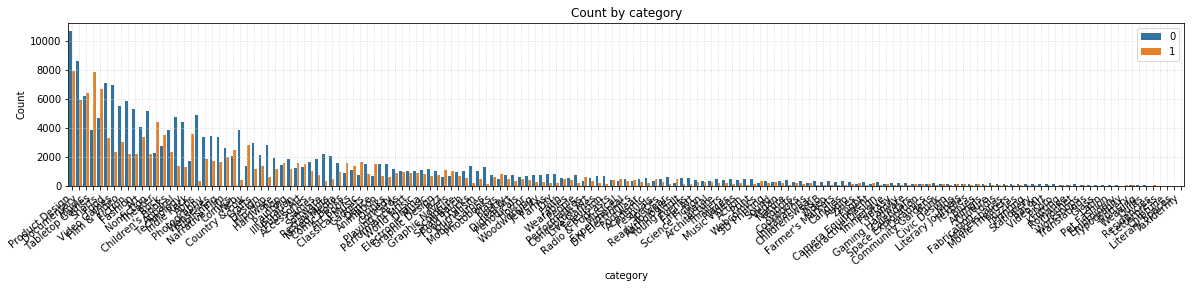



**▼ category件数順（Top10）**

,category
Product Design,18680
Documentary,14523
Music,12633
Tabletop Games,11744
Shorts,11394
Food,10416
Video Games,9328
Film & Video,8624
Fiction,8108
Fashion,7529




**▼ category別の成功率（降順）※赤線：学習データの平均成功率**

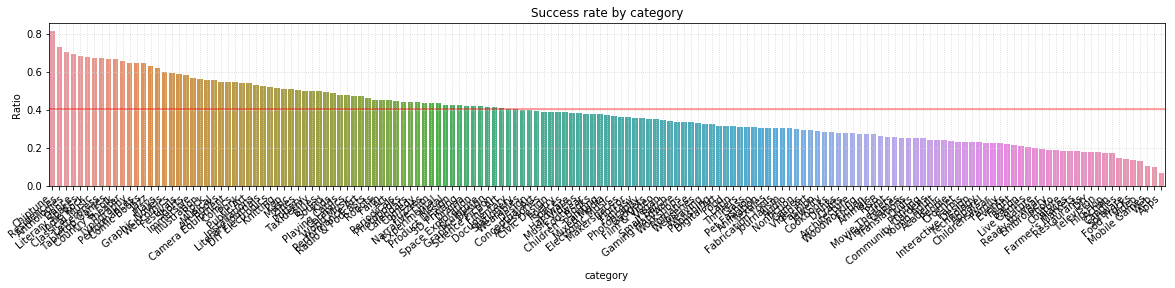



**▼ category成功率順（Top10）**

,state
category,
Chiptune,0.818182
Residencies,0.735294
Anthologies,0.706920
Dance,0.695221
Literary Spaces,0.684211
Indie Rock,0.678927
Classical Music,0.675000
Letterpress,0.673913
Tabletop Games,0.669789


→成功しやすいcategoryと失敗しやすいcategoryがありそう。


In [9]:
# main_categoryとcategoryの関係
printmd('▼ main_categoryとcategory別のカウントと成功率')
df_category = df[['main_category','category','state']]

display(df_category.groupby(['main_category', 'category']).agg(['count','mean']))
print('→main_categoryとcategoryは別々で考慮したほうが良さそう。')

# main_category
show_state_count_plot('main_category',9,3, True,40)
show_successrate_barplot('main_category',9,3, baseline,True,40)
print('→成功しやすいmain_categoryと失敗しやすいmain_categoryがありそう。')

# category
show_state_count_plot('category',20,3, True,40)

printmd('▼ category件数順（Top10）')
display(pd.DataFrame(df['category'].value_counts(),columns=['category']).head(10))

show_successrate_barplot('category',20,3, baseline,True,40)

printmd('▼ category成功率順（Top10）')
successrate = pd.DataFrame(df['state'].groupby(df['category']).mean())
successrate_s = successrate.sort_values('state', ascending=False) # 成功率降順
display(successrate_s.head(10))

print('→成功しやすいcategoryと失敗しやすいcategoryがありそう。')


### 2-3-6. 通貨と開催国（currency、country）



**▼ currencyとcountry別のカウントと成功率**

state          
                   count      mean
currency country                  
AUD      AU         6616  0.303809
         N,0"          5  0.200000
CAD      CA        12370  0.334196
         N,0"          5  0.600000
CHF      CH          652  0.286810
DKK      DK          926  0.388769
         N,0"          3  0.666667
EUR      AT          485  0.220619
         BE          523  0.290631
         DE         3436  0.272701
         ES         1873  0.262680
         FR         2520  0.360317
         IE          683  0.303075
         IT         2369  0.185310
         LU           57  0.333333
         N,0"         21  0.190476
         NL         2411  0.255910
GBP      GB        29454  0.409690
         N,0"         22  0.636364
HKD      HK          477  0.452830
JPY      JP           23  0.304348
MXN      MX         1411  0.280652
NOK      N,0"          2  0.500000
         NO          582  0.278351
NZD      NZ         1274  0.351648
SEK      N,0"          1  0.000000
         SE         1509  0.337309
SGD      SG          454  0.392070
USD      N,0"        151  0.529801
         US       261360  0.418193

→country=N,0"について、除外する




**▼ currency別の成功数と失敗数（降順）**

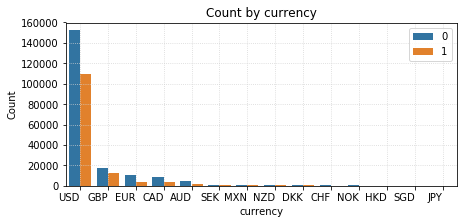



**▼ currency別の成功率（降順）※赤線：学習データの平均成功率**

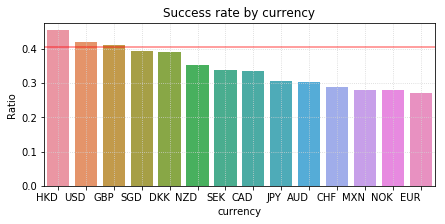



**▼ country別の成功数と失敗数（降順）**

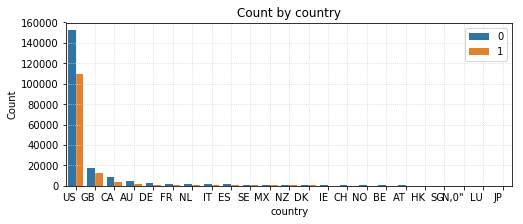



**▼ country別の成功率（降順）※赤線：学習データの平均成功率**

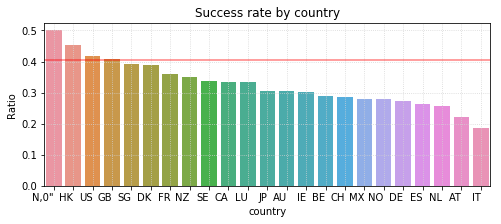

→currencyとcountryは関連しているので、どちらか一方でよいかも。


In [10]:
# currencyとcountryの関係を確認
printmd('▼ currencyとcountry別のカウントと成功率')

df_currency = df[['currency','country','state']]
display(df_currency.groupby(['currency','country']).agg(['count','mean']))

print('→country=N,0\"について、除外する')
#df = df[(df['country'] != 'N,0"')]

# currency
show_state_count_plot('currency',7,3,True)
show_successrate_barplot('currency',7,3,baseline,True)

# country
show_state_count_plot('country',8,3,True)
show_successrate_barplot('country',8,3,baseline,True)

print('→currencyとcountryは関連しているので、どちらか一方でよいかも。')


### 2-3-7. 名称の文字数と単語数、最終文字（name_char_length／name_word_num／name_end_char）



**▼ 最終文字の種類**

Other    290685
!         26296
.         13188
?          1506
Name: name_end_char, dtype: int64
→nameの最終文字を「!」と「?」と「.」とそれ以外「Other」に分割して比較する。




**▼ name_end_char別の成功数と失敗数**

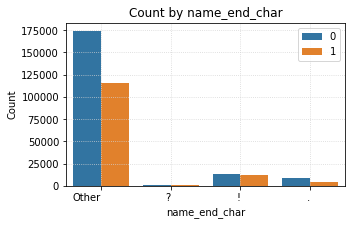



**▼ name_end_char別の成功率 ※赤線：学習データの平均成功率**

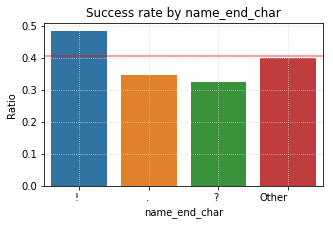

→「！」で終わらすのがよさそう。




**▼ name_char_lengthの分布 ※歪度：0.12789205186789132**

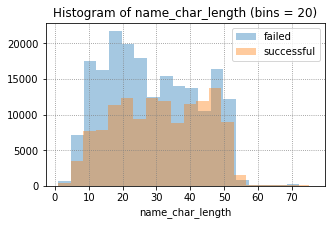

→文字数が少ないと失敗しやすいように見える。




**▼ name_char_length別の成功数と失敗数**

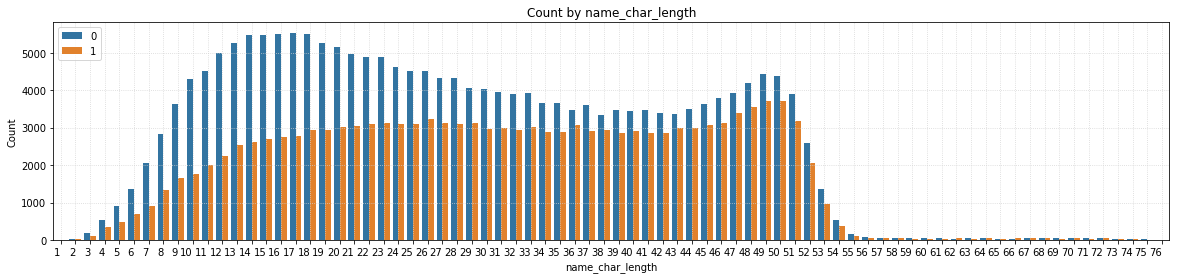



**▼ name_char_length別の成功率 ※赤線：学習データの平均成功率**

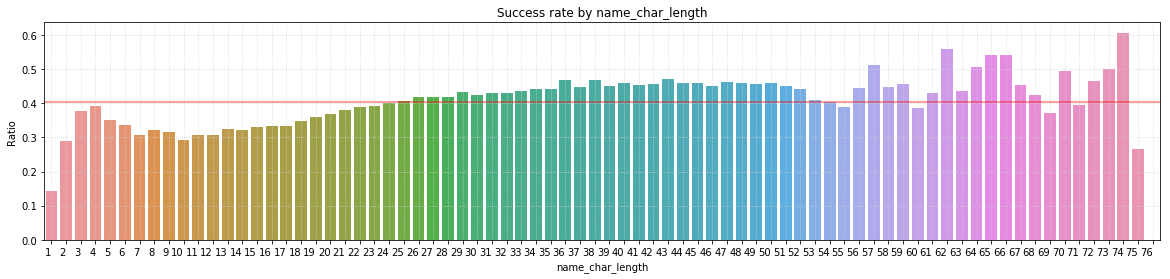

→若干は、成功しやすさの要因になると考えられる。




**▼ name_word_numの分布 ※歪度：0.36239305821649453**

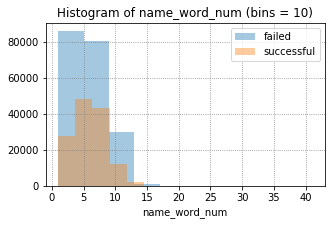



**▼ name_word_num別の成功数と失敗数**

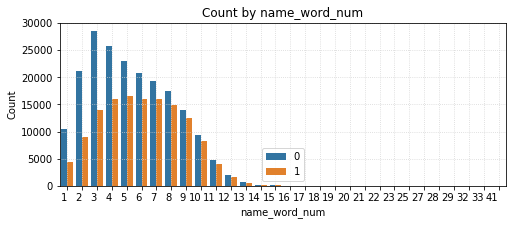



**▼ name_word_num別の成功率 ※赤線：学習データの平均成功率**

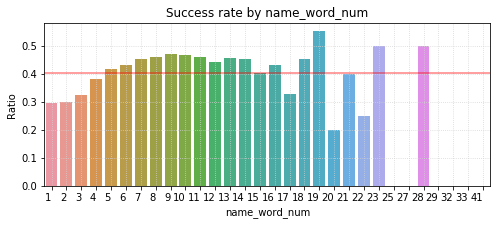

In [11]:
#print(df.name_end_char.value_counts())
df.name_end_char = np.where((df.name_end_char!='!') & (df.name_end_char!='?') & (df.name_end_char!='.'),
                            'Other',df.name_end_char)

printmd('▼ 最終文字の種類')
print(df.name_end_char.value_counts())
print('→nameの最終文字を「!」と「?」と「.」とそれ以外「Other」に分割して比較する。')
show_state_count_plot('name_end_char',5,3)
show_successrate_barplot('name_end_char',5,3,baseline)
print('→「！」で終わらすのがよさそう。')

show_histogram('name_char_length',5,3,20)
print('→文字数が少ないと失敗しやすいように見える。')
show_state_count_plot('name_char_length',20,4)
show_successrate_barplot('name_char_length',20,4,baseline)
print('→若干は、成功しやすさの要因になると考えられる。')

show_histogram('name_word_num',5,3,10)
show_state_count_plot('name_word_num',8,3)
show_successrate_barplot('name_word_num',8,3,baseline)


## 2-4. 無相関化（name_word_numとname_char_length）



**▼ name_word_num と name_char_length の相関 ※相関係数: 0.877**

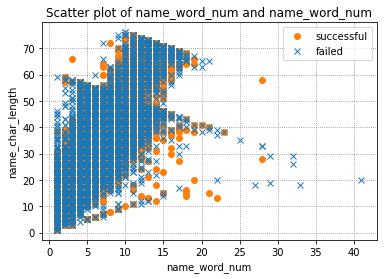

→無相関化してみる




**▼ name_word_num と name_char_length の相関 ※相関係数: -0.000**

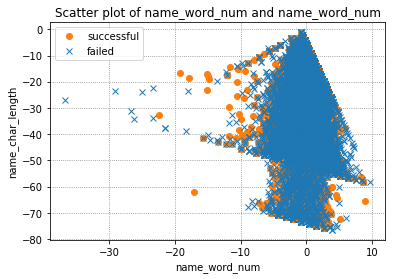

In [12]:
# 相関関係の散布図
show_corr_scatter_plot('name_word_num','name_char_length',6,4)

if(decorr_flg):
    # 無相関化する場合
    print('→無相関化してみる')
    f_write('│無相関化する')
    cov_data = df[['name_word_num','name_char_length']].values
    cov = np.cov(cov_data, rowvar=0)            # 分散・共分散を求める
    _, S = np.linalg.eig(cov)                   # 分散共分散行列の固有ベクトルを用いて
    cov_data_decorr = np.dot(S.T, cov_data.T).T # データを無相関化

    df['name_word_num'] = cov_data_decorr[:,0]
    df['name_char_length'] = cov_data_decorr[:,1]

    # 無相関化後の散布図
    show_corr_scatter_plot('name_word_num','name_char_length',6,4)
else:
    # 無相関化しない場合
    print('→無相関化しない')
    f_write('│無相関化しない')

## 2-5.目的変数と説明変数の関係


▼ stateと説明変数（数値項目）の相関関係を確認


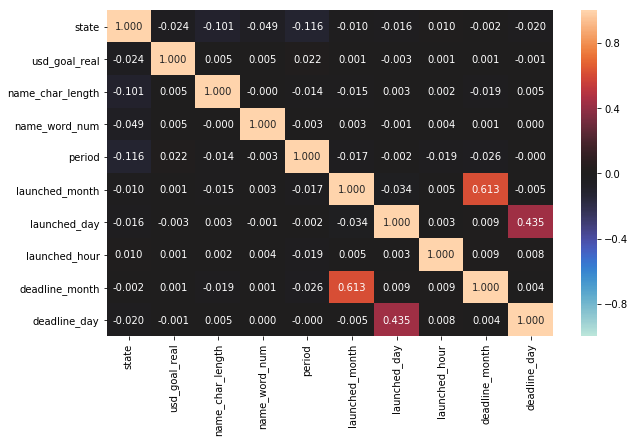

→stateと強い相関があるものはなさそう。


In [13]:
print('\n▼ stateと説明変数（数値項目）の相関関係を確認')
plt.figure(figsize=(10,6))
sns.heatmap(df.corr(), annot=True, fmt='1.3f', vmax=1, vmin=-1, center=0)
plt.show()
print('→stateと強い相関があるものはなさそう。')

## 2-6.データ絞込と説明変数の組み合わせを制御

In [14]:
# データ絞り込む為、念のためシャッフル
tmp_df = df.iloc[np.random.RandomState(seed=1234).permutation(len(df))]

# 計算時間を考慮してデータ絞込
if squeeze_num > 0:
    tmp_df = tmp_df[0:squeeze_num]
    
# 標準化＆白色化する項目リスト
enc_norm_col = ['usd_goal_real','name_word_num','name_char_length']

# カテゴリ項目組み合わせ制御（除外するしない、ダミー変換するしない)
enc_dic = {'main_category':[0,1],
           'category':[0,1],
           'country':[0,1],
           'currency':[0,1],
           'launched_month':[0,1],
           'deadline_month':[0,1],
           'launched_day':[0,1],
           'deadline_day':[0,1],
           'launched_hour':[0,1],
           'period':[0,1],
           'name_end_char':[0,1],
          }

# カテゴリ項目リスト生成
list_one_hot_cols = []
for k, v in enc_dic.items():
    if(v[0]==1): # drop
        tmp_df = tmp_df.drop(k,axis=1)
        print(k + ' is dropped. ')
        f_write('│' + k + ' を説明変数から除外')
    else:
        if(v[1]==1): # one-hot-encoding
            list_one_hot_cols.append(k)
    
printmd('▼ 行列')
print('tmp_df=',tmp_df.shape)

printmd('▼ 先頭3行表示')
display(tmp_df.head(3))



**▼ 行列**

tmp_df= (11000, 15)




**▼ 先頭3行表示**

,category,main_category,currency,state,country,usd_goal_real,name_char_length,name_word_num,name_end_char,period,launched_month,launched_day,launched_hour,deadline_month,deadline_day
189671,Music,Music,USD,0,US,500.0,-38.196083,-3.171633,Other,40,2,6,21,3,19
362547,Product Design,Design,USD,1,US,2500.0,-43.557551,0.860074,!,24,11,13,20,12,8
66851,Hip-Hop,Music,USD,0,US,300.0,-29.426292,0.305545,Other,59,5,19,0,7,18


## 2-7. データ分割（ホールドアウト法）
- https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

In [15]:
X_train_df, X_test_df, y_train_df, y_test_df = train_test_split(tmp_df.drop('state', axis=1), tmp_df['state'],
                                                                test_size=0.3, random_state=1234)

printmd('▼ データ分割後行列')
print('X_train_df=',X_train_df.shape)
print('y_train_df=',y_train_df.shape)
print('X_test_df=',X_test_df.shape)
print('y_test_df=',y_test_df.shape)

printmd('▼ 先頭3行表示')
display(tmp_df.head(3))



**▼ データ分割後行列**

X_train_df= (7700, 14)
y_train_df= (7700,)
X_test_df= (3300, 14)
y_test_df= (3300,)




**▼ 先頭3行表示**

,category,main_category,currency,state,country,usd_goal_real,name_char_length,name_word_num,name_end_char,period,launched_month,launched_day,launched_hour,deadline_month,deadline_day
189671,Music,Music,USD,0,US,500.0,-38.196083,-3.171633,Other,40,2,6,21,3,19
362547,Product Design,Design,USD,1,US,2500.0,-43.557551,0.860074,!,24,11,13,20,12,8
66851,Hip-Hop,Music,USD,0,US,300.0,-29.426292,0.305545,Other,59,5,19,0,7,18


## 2-8.カテゴリ変換
- URL:https://contrib.scikit-learn.org/categorical-encoding/onehot.html

In [16]:
# one-hot-encoding
ce_ohe = ce.OneHotEncoder(cols=list_one_hot_cols, use_cat_names=True)
enc_X_train_df = ce_ohe.fit_transform(X_train_df)
enc_X_test_df = ce_ohe.transform(X_test_df)

printmd('▼ カテゴリ変換後行列')
print('enc_X_train_df=',enc_X_train_df.shape)
print('enc_X_test_df=',enc_X_test_df.shape)

printmd('▼ カテゴリ変換後')
display(enc_X_train_df.head(5))



**▼ カテゴリ変換後行列**

enc_X_train_df= (7700, 407)
enc_X_test_df= (3300, 407)




**▼ カテゴリ変換後**

,category_Product Design,category_Tabletop Games,category_Horror,category_Video Games,category_Photography,category_Documentary,category_Rock,category_Academic,category_Crochet,category_Immersive,category_Hip-Hop,category_Live Games,category_Music,category_Electronic Music,category_Theater,category_Childrenswear,category_Restaurants,category_Festivals,category_Apparel,category_Nonfiction,category_Public Art,category_Sound,category_Games,category_Art Books,category_Conceptual Art,category_Mobile Games,category_Children's Books,category_Art,category_Drama,category_Classical Music,category_Thrillers,category_Comedy,category_Textiles,category_Comic Books,category_Apps,category_Cookbooks,category_Fashion,category_Video,category_Television,category_Performances,category_Software,category_Technology,category_Shorts,category_Fiction,category_Webseries,category_Video Art,category_World Music,category_Places,category_Family,category_Bacon,category_Accessories,category_Drinks,category_Graphic Novels,category_Food,category_Narrative Film,category_Publishing,category_Indie Rock,category_Gadgets,category_Design,category_Food Trucks,category_Film & Video,category_Animals,category_Poetry,category_Web,category_Footwear,category_Graphic Design,category_Pet Fashion,category_Sculpture,category_Musical,category_Ceramics,category_Small Batch,category_Woodworking,category_Dance,category_Comics,category_Ready-to-wear,category_DIY,category_Mixed Media,category_Pop,category_Photobooks,category_Crafts,category_Periodicals,category_Jazz,category_Country & Folk,category_Wearables,category_Journalism,category_Robots,category_Plays,category_Architecture,category_Print,category_Stationery,category_Painting,category_Animation,category_Performance Art,category_Action,category_3D Printing,category_Playing Cards,category_Gaming Hardware,category_Faith,category_Hardware,category_Anthologies,category_Fine Art,category_Nature,category_Civic Design,category_Photo,category_Illustration,category_Zines,category_Fantasy,category_Installations,category_Jewelry,category_Music Videos,category_Science Fiction,category_People,category_Fabrication Tools,category_DIY Electronics,category_Digital Art,category_Young Adult,category_Romance,category_Couture,category_Radio & Podcasts,category_Events,category_Vegan,category_Farms,category_Metal,category_Farmer's Markets,category_Embroidery,category_Glass,category_Interactive Design,category_Calendars,category_Experimental,category_Webcomics,category_Flight,category_R&B,category_Camera Equipment,category_Space Exploration,category_Puzzles,category_Makerspaces,category_Punk,category_Spaces,category_Workshops,category_Letterpress,category_Movie Theaters,category_Candles,category_Kids,category_Audio,category_Printing,category_Blues,category_Weaving,category_Knitting,category_Literary Journals,category_Translations,category_Quilts,category_Community Gardens,category_Latin,category_Pottery,category_Residencies,main_category_Design,main_category_Games,main_category_Film & Video,main_category_Photography,main_category_Music,main_category_Publishing,main_category_Crafts,main_category_Theater,main_category_Fashion,main_category_Food,main_category_Art,main_category_Technology,main_category_Comics,main_category_Journalism,main_category_Dance,currency_USD,currency_CAD,currency_GBP,currency_EUR,currency_HKD,currency_NZD,currency_DKK,currency_MXN,currency_SEK,currency_AUD,currency_SGD,currency_NOK,currency_CHF,country_US,country_CA,country_GB,country_NL,country_ES,country_HK,country_DE,country_NZ,country_DK,country_MX,country_FR,country_SE,country_AT,country_IT,country_AU,country_SG,country_NO,"country_N,0""",country_IE,country_CH,country_BE,country_LU,usd_goal_real,name_char_length,name_word_num,name_end_char_Other,name_end_char_.,name_end_char_!,name_end_char_?,period_30.0,period_29.0,period_13.0,period_44.0,period_43.0,period_34.0,period_19.0,period_14.0,period_42.0,period_7.0,period_6.0,period_35.0,period_47.0,period_59.0,period_61.0,period_58

## 2-9. 標準化
- https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html



**▼ndarray変換**

X_train.shape= (7700, 407)




**▼標準化対象列**

{'usd_goal_real': 205, 'name_word_num': 207, 'name_char_length': 206}




**▼標準化**

<Figure size 432x288 with 0 Axes>

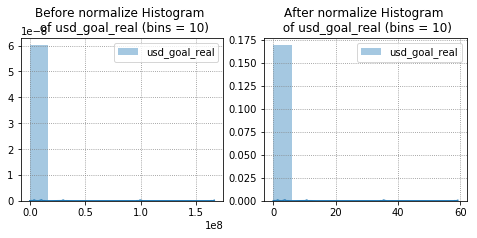

<Figure size 432x288 with 0 Axes>

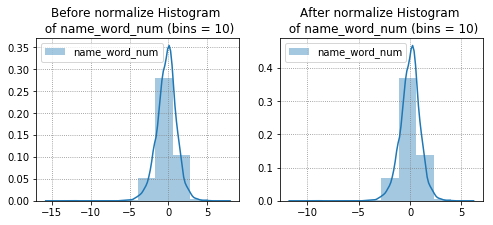

<Figure size 432x288 with 0 Axes>

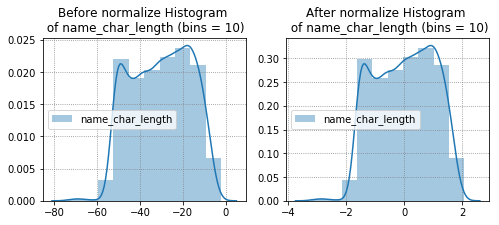

In [17]:
# 標準化する列名と列番号の辞書
dic_norm_col = {}
for col_name in enc_norm_col:
    dic_norm_col.setdefault(col_name, enc_X_train_df.columns.get_loc(col_name))
X_columns = enc_X_train_df.columns
    
# ndarrayに変換
X_train = enc_X_train_df.values
y_train = y_train_df.values
X_test = enc_X_test_df.values
y_test = y_test_df.values

printmd('▼ndarray変換')
print('X_train.shape=',X_train.shape)

printmd('▼標準化対象列')
print(dic_norm_col)

printmd('▼標準化')
for col_name,col_idx in dic_norm_col.items():
    
    plt.subplots_adjust(wspace=8.0, hspace=2.0) # 余白
    plt.figure(figsize=(8,3))
    
    # 標準化前
    plt.subplot(1,2,1)
    sns.distplot(X_train[:,col_idx:col_idx+1],kde=True,rug=False,bins=10,label=col_name)
    plt.title('Before normalize Histogram \n of ' + str(col_name) + ' (bins = ' + str(10) + ')')
    plt.grid(which='major',color='gray',linestyle=':')
    plt.grid(which='minor',color='gray',linestyle=':')
    plt.legend()
    
    # 標準化
    stdsc = StandardScaler()
    X_train[:,col_idx:col_idx+1] = stdsc.fit_transform(X_train[:,col_idx:col_idx+1])
    X_test[:,col_idx:col_idx+1] = stdsc.transform(X_test[:,col_idx:col_idx+1])
    
    #　標準化後
    plt.subplot(1,2,2)
    sns.distplot(X_train[:,col_idx:col_idx+1],kde=True,rug=False,bins=10,label=col_name)
    plt.title('After normalize Histogram \n of ' + str(col_name) + ' (bins = ' + str(10) + ')')
    plt.grid(which='major',color='gray',linestyle=':')
    plt.grid(which='minor',color='gray',linestyle=':')
    plt.legend()
    plt.show()
    

# 3.モデル構築
## 3-1. パラメーターチューニング

In [18]:
dic_models = {} # アルゴリズムごとに結果を格納
kfold = KFold(n_splits=5, random_state=1234)

### 3-1-1. ロジスティック回帰
- URL:https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html

In [19]:
lr_clf = SGDClassifier(loss='log',max_iter=10000,fit_intercept=True,random_state=1234,tol=1e-3)
lr_param_grid = {'penalty' : ['none','l1','l2','elasticnet'],#正則化項（default = 'l2'）
                 'alpha' : [1e-4, 1e-3] # 正則化項の効き具合(default = 0.0001:1e-4)
                }
grid = GridSearchCV(estimator=lr_clf, param_grid=lr_param_grid, scoring='accuracy', cv=kfold, n_jobs=-1)
grid_result = grid.fit(X_train, y_train)
dic_models.setdefault('LogisticRegression', grid_result) # 辞書に格納
best_lr = grid_result.best_estimator_
# 結果
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("Score: %f (%f) with: %r" % (mean, stdev, param))
    print("----------------------------------------------")
print("★BestScore: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Score: 0.654805 (0.013273) with: {'alpha': 0.0001, 'penalty': 'none'}
----------------------------------------------
Score: 0.657662 (0.005470) with: {'alpha': 0.0001, 'penalty': 'l1'}
----------------------------------------------
Score: 0.645195 (0.011070) with: {'alpha': 0.0001, 'penalty': 'l2'}
----------------------------------------------
Score: 0.651429 (0.007742) with: {'alpha': 0.0001, 'penalty': 'elasticnet'}
----------------------------------------------
Score: 0.653377 (0.009414) with: {'alpha': 0.001, 'penalty': 'none'}
----------------------------------------------
Score: 0.649351 (0.007289) with: {'alpha': 0.001, 'penalty': 'l1'}
----------------------------------------------
Score: 0.657273 (0.004672) with: {'alpha': 0.001, 'penalty': 'l2'}
----------------------------------------------
Score: 0.657273 (0.005329) with: {'alpha': 0.001, 'penalty': 'elasticnet'}
----------------------------------------------
★BestScore: 0.657662 using {'alpha': 0.0001, 'penalty': 'l1'}


### 3-1-2. サポートベクターマシン
- URL:https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC

In [20]:
svc_clf = SVC()
svc_param_grid = [{'kernel': ['linear'], 'C': [0.1,1]},
                  {'kernel': ['rbf'], 'gamma': [0.1, 1e-2],'C': [0.1,1],'random_state' : [1234]}
                 ]
grid = GridSearchCV(estimator=svc_clf, param_grid=svc_param_grid, scoring='accuracy', cv=kfold, n_jobs=-1)
grid_result = grid.fit(X_train, y_train)
dic_models.setdefault('SVM', grid_result) # 辞書に格納
best_SVC = grid_result.best_estimator_
# 結果
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("Score: %f (%f) with: %r" % (mean, stdev, param))
    print("----------------------------------------------")
print("★BestScore: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Score: 0.651818 (0.008841) with: {'C': 0.1, 'kernel': 'linear'}
----------------------------------------------
Score: 0.652468 (0.014020) with: {'C': 1, 'kernel': 'linear'}
----------------------------------------------
Score: 0.600779 (0.005814) with: {'C': 0.1, 'gamma': 0.1, 'kernel': 'rbf', 'random_state': 1234}
----------------------------------------------
Score: 0.600779 (0.005814) with: {'C': 0.1, 'gamma': 0.01, 'kernel': 'rbf', 'random_state': 1234}
----------------------------------------------
Score: 0.649351 (0.006296) with: {'C': 1, 'gamma': 0.1, 'kernel': 'rbf', 'random_state': 1234}
----------------------------------------------
Score: 0.644416 (0.008611) with: {'C': 1, 'gamma': 0.01, 'kernel': 'rbf', 'random_state': 1234}
----------------------------------------------
★BestScore: 0.652468 using {'C': 1, 'kernel': 'linear'}


## 3-2. 学習曲線
- URL:https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.learning_curve.html

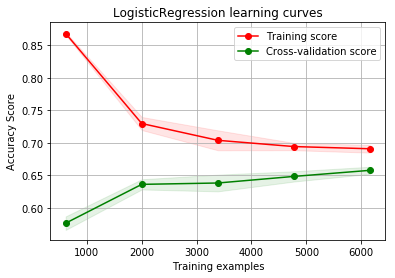

' 時間がかかりすぎるため、やらない\n# SVCの学習曲線\nplot_learning_curve(best_SVC,"SVM learning curves",X_train,y_train,cv=kfold)\n'

In [21]:
# ロジスティック回帰の学習曲線
plot_learning_curve(best_lr,"LogisticRegression learning curves",X_train,y_train,cv=kfold)
''' 時間がかかりすぎるため、やらない
# SVCの学習曲線
plot_learning_curve(best_SVC,"SVM learning curves",X_train,y_train,cv=kfold)
'''

## 3-3. 学習



**▼ BestModel**

LogisticRegression：{'alpha': 0.0001, 'penalty': 'l1'}




**▼ 重みを表示（絶対値の降順：Top10）**

,feature,weight
0,usd_goal_real,-24.940412
1,category_Embroidery,-3.888059
2,category_Latin,-2.751728
3,period_88.0,2.573505
4,category_Web,-1.772196
5,category_Space Exploration,1.740631
6,category_Apps,-1.568405
7,category_Hip-Hop,-1.567301
8,category_DIY Electronics,1.395067
9,period_60.0,-1.377615




**▼ 重みの大きさを横棒グラフで表示**

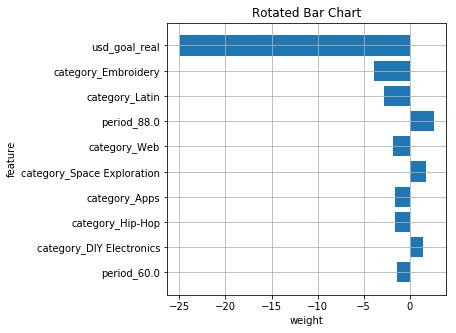



**▼ 重みを表示（絶対値の昇順：Top10）※説明変数から除外する候補**

,feature,weight
0,country_BE,0.0
1,category_Small Batch,0.0
2,category_Musical,0.0
3,category_Sculpture,0.0
4,category_Graphic Design,0.0
5,deadline_month_11.0,0.0
6,category_Design,0.0
7,deadline_month_5.0,0.0
8,category_Publishing,0.0
9,deadline_day_6.0,0.0


In [22]:
# 最良スコアのモデルを取得
first_flg = True
f_write('│▽検証したアルゴリズム数：' + str(len(dic_models)))
for k,grid_result in dic_models.items():
    tmp_score = grid_result.best_score_
    f_write('│' + str(k) + ' :  {:.3f}%'.format(tmp_score * 100))
    if (first_flg):
        max_score = tmp_score
        best_model = k
        best_clf = grid_result.best_estimator_
        best_param = grid_result.best_params_
        first_flg = False
    if (max_score < tmp_score):
        max_score = tmp_score
        best_model = k
        best_clf = grid_result.best_estimator_
        best_param = grid_result.best_params_

printmd('▼ BestModel')
print(str(best_model) + '：' + str(best_param))

# 学習
best_clf.fit(X_train, y_train)

if(str(best_clf).find("kernel='rbf'") > 0):
    # 重みチェックしない
    pass
else:
    # 結果をDataFrameへ格納
    res_df = pd.DataFrame(columns=['feature','weight','abs_w'])
    res_df['feature'] = list(X_columns)
    res_df['weight'] = np.reshape(best_clf.coef_[0], -1).tolist() # 重み
    res_df['abs_w'] = abs(res_df['weight']) # 絶対値

    # 重みの絶対値の降順ソート
    printmd('▼ 重みを表示（絶対値の降順：Top10）')
    res_df = res_df.sort_values('abs_w', ascending=False)
    res_df.reset_index(drop=True,inplace=True)
    res_df_head_desc = res_df.head(10)
    res_df_head_desc = res_df_head_desc.drop('abs_w', axis=1)
    display(res_df_head_desc.head(10))

    # 重みの大きさを横棒グラフで表示
    printmd('▼ 重みの大きさを横棒グラフで表示')
    plt.figure(figsize=(5, 5))
    plt.barh(np.arange(len(res_df_head_desc['feature']))[::-1], res_df_head_desc['weight'], align='center')
    plt.yticks(np.arange(len(res_df_head_desc['feature']))[::-1], res_df_head_desc['feature'])
    plt.title('Rotated Bar Chart')
    plt.xlabel('weight')
    plt.ylabel('feature')
    plt.grid()
    plt.show()

    # 重みの絶対値の降順ソート
    printmd('▼ 重みを表示（絶対値の昇順：Top10）※説明変数から除外する候補')
    res_df = res_df.sort_values('abs_w', ascending=True)
    res_df.reset_index(drop=True,inplace=True)
    res_df_head_asc = res_df.head(10)
    res_df_head_asc = res_df_head_asc.drop('abs_w', axis=1)
    display(res_df_head_asc.head(10))


# 4.モデル評価

In [23]:
# 予測
y_train_pred = best_clf.predict(X_train) # 訓練データ
y_test_pred = best_clf.predict(X_test) # テストデータ

# 正答率
score_train = 100 * accuracy_score(y_train, y_train_pred)
score_test = 100 * accuracy_score(y_test, y_test_pred)

# Precision, Recall, F1-score計算
precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_test_pred)
v_precision = 100 * precision[0]
v_recall= 100 * recall[0]
v_F1 = 100 * f1_score[0]

printmd('▼ Day2 モデルの評価結果')
print('最良モデル = ' + str(best_model) + '：' + str(best_param))
print('データ数（test_size=0.3） = ' + str(len(tmp_df)))
print('説明変数の数（one-hot前） = ' + str(len(X_train_df.columns)))
print('対数尤度 = {:.3f}'.format(- log_loss(y_test, y_test_pred)))
print('正答率（訓練データ） = {:.3f}%'.format(score_train))
print('正答率（テストデータ）= {:.3f}% ※汎化性能'.format(score_test))
print('適合率（Precision※精度) = {:.3f}%'.format(v_precision))
print('再現率（Recall※検出率) = {:.3f}%'.format(v_recall))
print('F1値（F1-score） = {:.3f}%'.format(v_F1))
printmd('▼ 混同行列')
conf_mat = pd.DataFrame(confusion_matrix(y_test, y_test_pred), 
                        index=['正解 = 資金調達失敗', '正解 = 資金調達成功'], 
                        columns=['予測 = 資金調達失敗', '予測 = 資金調達成功'])
display(conf_mat)

# 計算時間
proc_time = time() - start_notebook
print('計算時間（分）：{:.2f}'.format(proc_time / 60)) 

# 結果をファイル出力
f_write('│▽最良モデル')
f_write('│' + str(best_model) + '：' + str(best_param))
f_write('│▽使用データ')
f_write('│データ数（test_size=0.3） = ' + str(len(tmp_df)))
f_write('│説明変数の数（one-hot前） = ' + str(len(X_train_df.columns)))
f_write('│▽評価結果')
f_write('│対数尤度 = {:.3f}'.format(- log_loss(y_test, y_test_pred)))
f_write('│正答率（訓練データ） = {:.3f}%'.format(score_train))
f_write('│正答率（テストデータ）= {:.3f}% ※汎化性能'.format(score_test))
f_write('│適合率（Precision※精度) = {:.3f}%'.format(v_precision))
f_write('│再現率（Recall※検出率) = {:.3f}%'.format(v_recall))
f_write('│F1値（F1-score） = {:.3f}%'.format(v_F1))
f_write('│計算時間（分）：{:.2f}'.format(proc_time / 60)) 
f_write('▲処理終了')



**▼ Day2 モデルの評価結果**

最良モデル = LogisticRegression：{'alpha': 0.0001, 'penalty': 'l1'}
データ数（test_size=0.3） = 11000
説明変数の数（one-hot前） = 14
対数尤度 = -11.314
正答率（訓練データ） = 69.286%
正答率（テストデータ）= 67.242% ※汎化性能
適合率（Precision※精度) = 71.598%
再現率（Recall※検出率) = 74.195%
F1値（F1-score） = 72.873%




**▼ 混同行列**

,予測 = 資金調達失敗,予測 = 資金調達成功
正解 = 資金調達失敗,1452,505
正解 = 資金調達成功,576,767


計算時間（分）：4.03


### ◆気になること
- 少ない件数にてロジスティック回帰もSVMも汎化性能がほぼ同じなので、計算の遅いSVMは対象外にしてもよいかもしれない。
- 学習曲線用の関数を使ってプロットしてみました。y軸が上がbadで下がgoodではなかったですが、これでもよいでしょうか。
- 対数変換は学習時にも有効と教えて頂きましたが、分布に偏りのある目標金額を対数変換して説明変数とすることは有効なのでしょうか。

### ────────────────────────────────────────────────────────────────
### ◆これまでの記録

#### Day1 モデルの評価結果（標準化なし）
- ロジスティック回帰モデル（正則化項なし）
- 対数尤度 = -14.931
- 正答率（訓練データ) = 56.772%
- 適合率（Precision※精度) = 73.061%
- 再現率（Recall※検出率) = 43.540%
- F1値（F1-score） = 54.563%